## Install Requests

In [ ]:
%%bash
pip install requests

## SANITY CHECK - Search for a song

In [1]:
import requests

# Token from Genius API
access_token = "0MSSVdpMbNPuX4u5LhP0sFUd5sajyinz28KOWgbs-F9CfrWE4-M_14kZVJckK3GP"

headers = {
    "Authorization": f"Bearer {access_token}"
}

def search_song(query):
    base_url = "https://api.genius.com"
    search_url = f"{base_url}/search"
    params = {"q": query}
    response = requests.get(search_url, params=params, headers=headers)
    return response.json()

# Search for a song
results = search_song("Welcome to New York Taylor Swift")
for hit in results["response"]["hits"][:3]:
    print("Title:", hit["result"]["full_title"])
    print("Genius URL:", hit["result"]["url"])
    print()


Title: Welcome to New York by Taylor Swift
Genius URL: https://genius.com/Taylor-swift-welcome-to-new-york-lyrics

Title: ​portorosso’s DISCONTINUED 2023 Listening Log by still-life starlet
Genius URL: https://genius.com/Still-life-starlet-portorossos-discontinued-2023-listening-log-annotated

Title: ​youth group - background music by Josiah Botting
Genius URL: https://genius.com/Josiah-botting-youth-group-background-music-annotated



# Set Up Table and Bucket

In [2]:
import boto3

# DDB table
dynamodb = boto3.resource('dynamodb')

table_name = 'genius-ddb-table'

table = dynamodb.create_table(
    TableName=table_name,
    KeySchema=[
        {
            'AttributeName': 'user_id',
            'KeyType': 'HASH'
        }
    ],
    AttributeDefinitions=[
        {
            'AttributeName': 'user_id',
            'AttributeType': 'S'
        }
    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 1,
        'WriteCapacityUnits': 1
    }
)

print(f"DDB table '{table_name}' created!")



DDB table 'genius-ddb-table' created!


In [3]:
import boto3

s3 = boto3.client('s3')

bucket_name = 'genius-s3-bucket-sowder'

s3.create_bucket(
    Bucket=bucket_name,
    CreateBucketConfiguration={'LocationConstraint': 'us-east-2'}
)

print(f"S3 bucket '{bucket_name}' created!")

S3 bucket 'genius-s3-bucket-sowder' created!


# Set up Lambda Function Connection

In [4]:
import boto3
import json

# SQS setup
sqs = boto3.client('sqs')
queue_name = 'genius-sqs-queue'

In [5]:
# create queue
try:
    response = sqs.create_queue(
        QueueName=queue_name,
        Attributes={
            'VisibilityTimeout': '60'
        }
    )
    queue_url = response['QueueUrl']
    print(f"SQS queue created: {queue_url}")
except sqs.exceptions.QueueNameExists:
    queue_url = [url for url in sqs.list_queues()['QueueUrls'] if queue_name in url][0]
    print(f"SQS queue already exists: {queue_url}")

SQS queue created: https://sqs.us-east-2.amazonaws.com/943814146063/genius-sqs-queue


In [6]:
# deploy and connect lambda function
lambda_client = boto3.client('lambda')
iam = boto3.client('iam')
sqs = boto3.client('sqs')

function_name = 'genius_lambda_function'
zip_path = 'genius_lambda.zip'
sqs_queue_url = queue_url
role = iam.get_role(RoleName='GeniusLambdaRole')['Role']['Arn']

with open(zip_path, 'rb') as f:
    zipped_code = f.read()

In [7]:
# create lambda function
try:
    response = lambda_client.create_function(
        FunctionName=function_name,
        Runtime='python3.9',
        Role=role,
        Handler='lambda_function.lambda_handler',
        Code={'ZipFile': zipped_code},
        Timeout=10
    )
    print("lambda function created!")
except lambda_client.exceptions.ResourceConflictException:
    print("lambda function already exists")
    response = lambda_client.update_function_code(
        FunctionName=function_name,
        ZipFile=zipped_code
    )

lambda function created!


In [8]:
# get ARN for trigger
sqs_attrs = sqs.get_queue_attributes(
    QueueUrl=sqs_queue_url,
    AttributeNames=['QueueArn']
)
sqs_arn = sqs_attrs['Attributes']['QueueArn']

In [9]:
# check that the function is there

lambda_client = boto3.client('lambda', region_name='us-east-2')
functions = lambda_client.list_functions()

for f in functions['Functions']:
    print(f['FunctionName'])

genius_lambda_function


In [10]:
# create SQS trigger
try:
    lambda_client.create_event_source_mapping(
        EventSourceArn=sqs_arn,
        FunctionName=function_name,
        Enabled=True,
        BatchSize=10
    )
    print("trigger creation successful")
except lambda_client.exceptions.ResourceConflictException:
    print("trigger already exists")

trigger already exists


## Set Up Lambda Environment Variable

In [11]:
import boto3

lambda_client = boto3.client('lambda')
function_name = 'genius_lambda_function'

with open('genius_lambda.zip', 'rb') as f:
    zipped_code = f.read()

lambda_client.update_function_code(
    FunctionName=function_name,
    ZipFile=zipped_code
)

{'ResponseMetadata': {'RequestId': 'a27e2f4f-a650-4e92-a669-d5cbf00d097c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 30 May 2025 04:17:13 GMT',
   'content-type': 'application/json',
   'content-length': '1364',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'a27e2f4f-a650-4e92-a669-d5cbf00d097c'},
  'RetryAttempts': 0},
 'FunctionName': 'genius_lambda_function',
 'FunctionArn': 'arn:aws:lambda:us-east-2:943814146063:function:genius_lambda_function',
 'Runtime': 'python3.9',
 'Role': 'arn:aws:iam::943814146063:role/GeniusLambdaRole',
 'Handler': 'lambda_function.lambda_handler',
 'CodeSize': 1822090,
 'Description': '',
 'Timeout': 10,
 'MemorySize': 128,
 'LastModified': '2025-05-30T04:17:13.000+0000',
 'CodeSha256': 'P4RrmuT0JFTCbt2yEkbvreZgy8OqOoio1PmwPzA3Bns=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '01b217f9-a873-4290-821e-b17db5b8e21c',
 'State': 'Active',
 'LastUpdateStatus': 'InProgress',
 'LastUpdateStatusReason':

In [12]:
import boto3

lambda_client = boto3.client('lambda')
function_name = 'genius_lambda_function' 

response = lambda_client.update_function_configuration(
    FunctionName=function_name,
    Environment={
        'Variables': {
            'GENIUS_API_TOKEN': '0MSSVdpMbNPuX4u5LhP0sFUd5sajyinz28KOWgbs-F9CfrWE4-M_14kZVJckK3GP'
        }
    }
)

print("Environment variable updated!")


Environment variable updated!


### Sanity Check

In [13]:
import boto3
import json

sqs = boto3.client('sqs')
queue_url = 'https://sqs.us-east-2.amazonaws.com/943814146063/genius-sqs-queue'

message_body = {
    "track_id": "123",
    "title": "Welcome to New York",
    "artist": "Taylor Swift"
}

response = sqs.send_message(
    QueueUrl=queue_url,
    MessageBody=json.dumps(message_body)
)

print("Message sent to SQS:", response['MessageId'])

Message sent to SQS: 47413f82-b264-4a9b-82c4-a10bdce43428


In [21]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'genius-s3-bucket-sowder'

response = s3.list_objects_v2(Bucket='genius-s3-bucket-sowder')
for obj in response.get('Contents', []):
    print(obj['Key'])

lyrics/TEST123.json


This confirms my entire pipeline is working end-to-end:
- Lambda is being triggered by SQS
- Lyrics are being scraped and stored in S3

# Use Dask to clean and match data

### 1. Set up AWS clients

In [48]:
import boto3
import json

region = 'us-east-2'
sqs_queue_url = 'https://sqs.us-east-2.amazonaws.com/943814146063/genius-sqs-queue'
s3_bucket = 'genius-s3-bucket-sowder'
dynamodb_table = 'genius-ddb-table'

s3 = boto3.client('s3', region_name=region)
sqs = boto3.client('sqs', region_name=region)
dynamodb = boto3.resource('dynamodb', region_name=region)
lambda_client = boto3.client('lambda', region_name=region)

### 2. Batch send messages from CSV using Dask

In [19]:
import dask.dataframe as dd

csv_df = dd.read_csv('final_joined_table.csv')
csv_df = csv_df[['track_id', 'title', 'artist']].dropna().drop_duplicates(subset=['title', 'artist'])

In [20]:
import boto3
import json

sqs = boto3.client('sqs')
queue_url = 'https://sqs.us-east-2.amazonaws.com/943814146063/genius-sqs-queue'

for i, row in enumerate(csv_df.head(6000).itertuples(index=False)):
    message = {
        "track_id": getattr(row, "track_id", ""),
        "title": getattr(row, "title", ""),
        "artist": getattr(row, "artist", "")
    }
    response = sqs.send_message(QueueUrl=queue_url, MessageBody=json.dumps(message))
    print(f"{i+1}: Sent '{message['title']}' by {message['artist']} — MsgID: {response['MessageId']}")

1: Sent 'Collapsing New People' by Fad Gadget — MsgID: 44c01b84-6230-4b4b-929b-ae54742473fe
2: Sent 'We Rule The Fucking Land' by Zimmers Hole — MsgID: 2004c108-6032-4686-8d48-d262641d46c1
3: Sent 'Blood' by Candiria — MsgID: 5c619a17-b1e5-43d8-9dad-11b7f8076003
4: Sent 'Deathly' by Aimee Mann — MsgID: ddf32d85-19af-4f9f-b9ec-4d12e8bf51ba
5: Sent 'My Definition Of A Boombastic Jazz Style' by Dream Warriors — MsgID: e2d2496e-188c-4070-80a4-9e0ba2f022c6
6: Sent 'Take A Load Off' by Bubba Sparxxx — MsgID: 47bc45f9-6967-461a-94bb-0c6358e5b043
7: Sent 'Rapper's Delight' by The Sugarhill Gang — MsgID: 000f5389-6fa0-4692-b5d2-b6ce71370a03
8: Sent 'So I Thought' by Flyleaf — MsgID: 84423174-3b66-4eeb-9e89-970ceb8051ec
9: Sent 'Twentytwofourteen' by The Album Leaf — MsgID: 5adda45f-fae7-48fc-9112-e48900b3e794
10: Sent '21st Century Boy' by Willy Mason — MsgID: ba0d7028-817b-412c-b92d-4273dc8ca467
11: Sent 'Edge Hill' by Groove Armada — MsgID: bb614388-27e0-4a6b-9c98-e150c4952c47
12: Sent 'When 

### 3. List objects in S3

In [22]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'genius-s3-bucket-sowder'

response = s3.list_objects_v2(Bucket='genius-s3-bucket-sowder')
for obj in response.get('Contents', []):
    print(obj['Key'])

lyrics/TEST123.json


### 4. Load S3 lyrics into Dask

In [ ]:
import dask.dataframe as dd

ddf = dd.read_json(
    "s3://genius-s3-bucket-sowder/lyrics/*.json",
    storage_options={
        'client_kwargs': {'region_name': 'us-east-2'}
    }
)

In [27]:
ddf.head()

,track_id,title,artist,lyrics
0,TRBAIGR12903CFE27D,Collapsing New People,Fad Gadget,8 Contributors Collapsing New People Lyrics Wh...
1,TRFYMLK12903CFEE3E,We Rule The Fucking Land,Zimmers Hole,1 Contributor We Rule the Fucking Land Lyrics ...
2,TRTRREY12903CDD9D4,Blood,Candiria,2 Contributors Blood Lyrics All is wasted Sacr...
3,TRIODBR128F4248265,Deathly,Aimee Mann,7 Contributors Deathly Lyrics [Verse 1] Now th...
4,TRGZHFZ128F145E59D,My Definition Of A Boombastic Jazz Style,Dream Warriors,7 Contributors My Definition of a Boombastic J...


### 5. Clean Lyrics

In [28]:
import dask.dataframe as dd
import re

def clean_lyrics(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\[.*?\]", "", text)               # remove [Verse] tags
    text = re.sub(r"\d+ Contributors?", "", text)     # remove "x Contributors"
    text = re.sub(r"\s{2,}", " ", text)               # collapse whitespace
    return text.strip()

ddf["clean_lyrics"] = ddf["lyrics"].map(clean_lyrics, meta=("clean_lyrics", "str"))


In [29]:
ddf.head()

,track_id,title,artist,lyrics,clean_lyrics
0,TRBAIGR12903CFE27D,Collapsing New People,Fad Gadget,8 Contributors Collapsing New People Lyrics Wh...,Collapsing New People Lyrics\nWhen Frank Tovey...
1,TRFYMLK12903CFEE3E,We Rule The Fucking Land,Zimmers Hole,1 Contributor We Rule the Fucking Land Lyrics ...,"We Rule the Fucking Land Lyrics\nAlright, let'..."
2,TRTRREY12903CDD9D4,Blood,Candiria,2 Contributors Blood Lyrics All is wasted Sacr...,Blood Lyrics\nAll is wasted\nSacrifice\nSpill ...
3,TRIODBR128F4248265,Deathly,Aimee Mann,7 Contributors Deathly Lyrics [Verse 1] Now th...,Deathly Lyrics Now that I've met you\nWould yo...
4,TRGZHFZ128F145E59D,My Definition Of A Boombastic Jazz Style,Dream Warriors,7 Contributors My Definition of a Boombastic J...,My Definition of a Boombastic Jazz Style Lyric...


### 6. Load BERTa Model to get emotion label from lyrics

In [37]:
from transformers import pipeline

emotion_classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/bert-base-go-emotion",
    top_k=10,
    device=-1,  # use CPU, or set to 0 if CUDA is available
    truncation=True
)

six_emotions = {'surprise', 'sadness', 'joy', 'fear', 'disgust', 'anger'}


Device set to use cpu


In [38]:
def classify_six_emotions_only(text):
    if not isinstance(text, str) or not text.strip():
        return None
    try:
        preds = emotion_classifier(text)
        for pred in preds[0]:  # Check top 10 predictions
            label = pred['label'].lower()
            if label in six_emotions:
                return label
    except Exception as e:
        print(f"[ERROR]: {e}")
    return None


### 7. Apply row-wise with Dask

In [39]:
def apply_emotion_prediction(partition):
    partition = partition.copy()
    partition["lyrics_emotion"] = partition["clean_lyrics"].map(classify_six_emotions_only)
    return partition

ddf = ddf.map_partitions(apply_emotion_prediction, meta=ddf)

ddf.head()

[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self


,track_id,title,artist,lyrics,clean_lyrics,lyrics_emotion
0,TRBAIGR12903CFE27D,Collapsing New People,Fad Gadget,8 Contributors Collapsing New People Lyrics Wh...,Collapsing New People Lyrics\nWhen Frank Tovey...,anger
1,TRFYMLK12903CFEE3E,We Rule The Fucking Land,Zimmers Hole,1 Contributor We Rule the Fucking Land Lyrics ...,"We Rule the Fucking Land Lyrics\nAlright, let'...",anger
2,TRTRREY12903CDD9D4,Blood,Candiria,2 Contributors Blood Lyrics All is wasted Sacr...,Blood Lyrics\nAll is wasted\nSacrifice\nSpill ...,anger
3,TRIODBR128F4248265,Deathly,Aimee Mann,7 Contributors Deathly Lyrics [Verse 1] Now th...,Deathly Lyrics Now that I've met you\nWould yo...,sadness
4,TRGZHFZ128F145E59D,My Definition Of A Boombastic Jazz Style,Dream Warriors,7 Contributors My Definition of a Boombastic J...,My Definition of a Boombastic Jazz Style Lyric...,anger


### 8. Merge in Tag-based emotion label from Vera's final_joined_table.csv

In [40]:
import pandas as pd
import dask.dataframe as dd

# Load tag-based emotion from CSV (smaller, so use pandas)
emotion_df = pd.read_csv("final_joined_table.csv")[["title", "emotion"]]
emotion_df.rename(columns={"emotion": "tag_emotion"}, inplace=True)


In [41]:
# Merge using Dask (on 'title')
ddf = ddf.merge(emotion_df, on="title", how="inner")


In [42]:
# Check that both emotion columns are now present
ddf[["title", "lyrics_emotion", "tag_emotion"]].head()


[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self


,title,lyrics_emotion,tag_emotion
0,Collapsing New People,anger,anger
1,We Rule The Fucking Land,anger,anger
2,Blood,anger,anger
3,Deathly,sadness,anger
4,Deathly,sadness,sadness


Why is ddf[["title", "lyrics_emotion", "tag_emotion"]].head() slow?
- Dask is Lazy - Dask doesn't compute until you explicitly request a result.

To speed up analysis: Persist the Merged Dask DataFrame
- Since I'm done transforming, I can tell Dask to cache the DataFrame in memory:

In [43]:
ddf = ddf.persist()

[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self
[PREDICTION ERROR] index out of range in self


## Analysis

In [44]:
df = ddf.compute()

In [48]:
# Drop rows where either emotion is missing
df = df.dropna(subset=["tag_emotion", "lyrics_emotion"])


              precision    recall  f1-score   support

       anger       0.19      0.50      0.27       432
     disgust       0.17      0.03      0.05       422
        fear       0.24      0.05      0.09       409
         joy       0.16      0.32      0.21       387
     sadness       0.18      0.16      0.17       421
    surprise       0.21      0.04      0.06       438

    accuracy                           0.18      2509
   macro avg       0.19      0.18      0.14      2509
weighted avg       0.19      0.18      0.14      2509



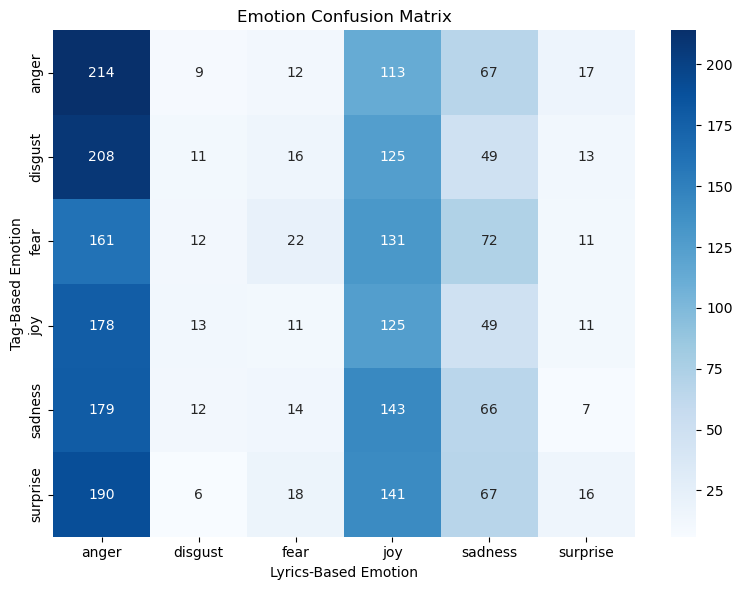

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define emotion classes
emotion_labels = sorted(df["tag_emotion"].dropna().unique().tolist())

# Text report
print(classification_report(df["tag_emotion"], df["lyrics_emotion"], labels=emotion_labels))

# Confusion matrix
cm = confusion_matrix(df["tag_emotion"], df["lyrics_emotion"], labels=emotion_labels)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel("Lyrics-Based Emotion")
plt.ylabel("Tag-Based Emotion")
plt.title("Emotion Confusion Matrix")
plt.tight_layout()
plt.show()


Overall agreement: 18.09%
tag_emotion
anger       0.495370
disgust     0.026066
fear        0.053790
joy         0.322997
sadness     0.156770
surprise    0.036530
dtype: float64


/var/folders/hr/wd6z7xjs1cv5v4pw0v06v7vm0000gn/T/ipykernel_65970/4025505939.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_emotion_agreement = df.groupby("tag_emotion").apply(
/var/folders/hr/wd6z7xjs1cv5v4pw0v06v7vm0000gn/T/ipykernel_65970/4025505939.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_agree.values, y=emotion_agree.index, palette="coolwarm")


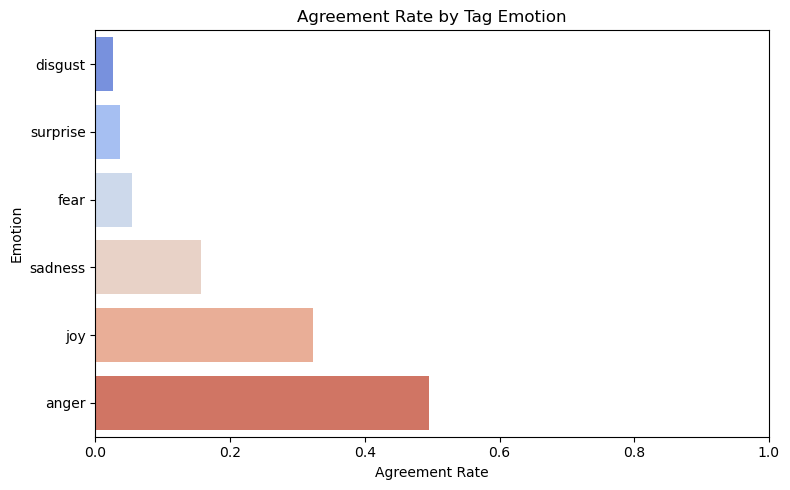

In [64]:
# Overall agreement
agreement_rate = (df["tag_emotion"] == df["lyrics_emotion"]).mean()
print(f"Overall agreement: {agreement_rate:.2%}")

# Per-emotion agreement
per_emotion_agreement = df.groupby("tag_emotion").apply(
    lambda x: (x["tag_emotion"] == x["lyrics_emotion"]).mean()
)

print(per_emotion_agreement)

# Create agreement column
df["agree"] = df["tag_emotion"] == df["lyrics_emotion"]

# Compute agreement per emotion
emotion_agree = df.groupby("tag_emotion")["agree"].mean().sort_values()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=emotion_agree.values, y=emotion_agree.index, palette="coolwarm")
plt.title("Agreement Rate by Tag Emotion")
plt.xlabel("Agreement Rate")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


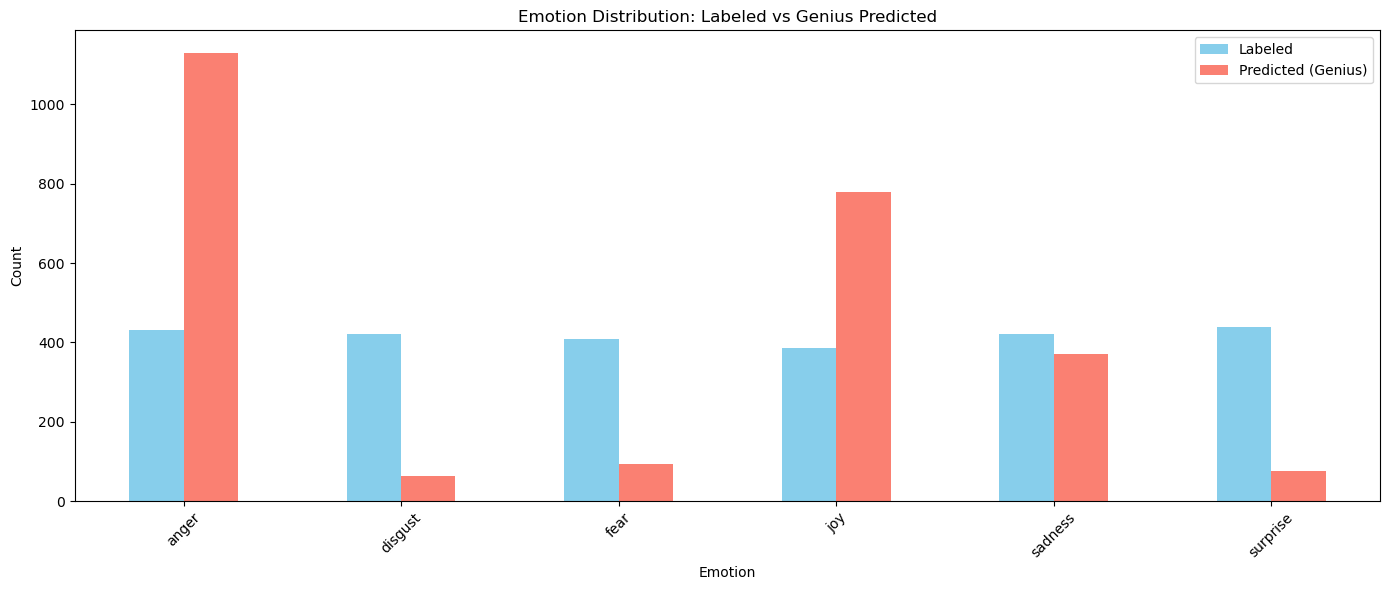

In [65]:
# Count frequencies
label_counts = df['tag_emotion'].value_counts().sort_index()
genius_counts = df['lyrics_emotion'].value_counts().sort_index()

# Combine into single DataFrame
emotion_compare = pd.DataFrame({
    'Labeled': label_counts,
    'Predicted (Genius)': genius_counts
}).fillna(0)

# Plot
emotion_compare.plot(kind='bar', figsize=(14,6), color=["skyblue", "salmon"])
plt.title("Emotion Distribution: Labeled vs Genius Predicted")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

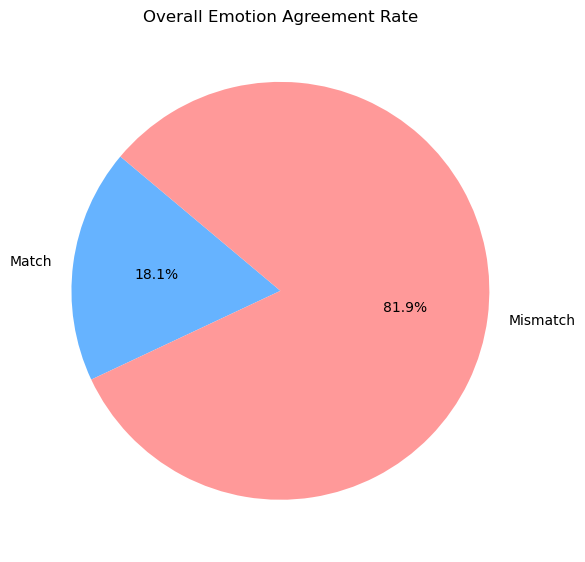

In [52]:
# Compute match rate
df['match'] = df['tag_emotion'] == df['lyrics_emotion']
agreement_rate = df['match'].mean()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie([agreement_rate, 1 - agreement_rate],
        labels=['Match', 'Mismatch'],
        autopct='%1.1f%%',
        colors=['#66b3ff', '#ff9999'],
        startangle=140)
plt.title("Overall Emotion Agreement Rate")
plt.tight_layout()
plt.show()


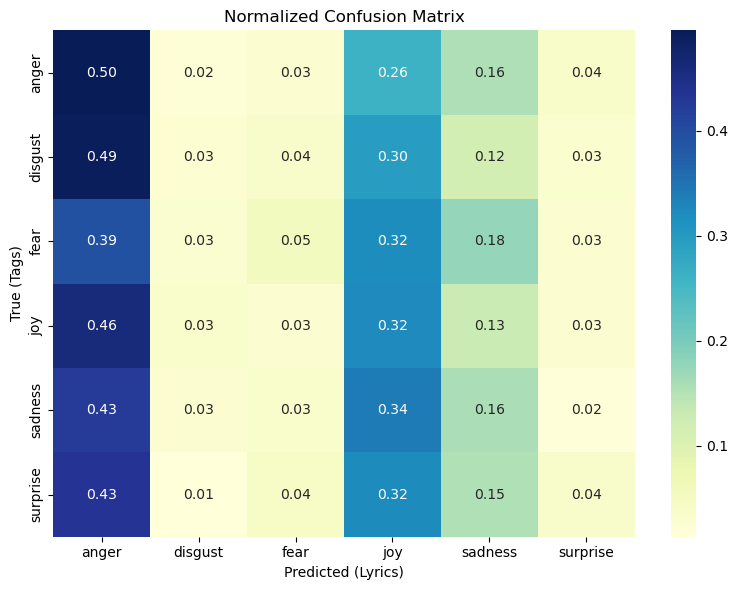

In [54]:
from sklearn.metrics import confusion_matrix
import numpy as np

eval_df = df.dropna(subset=["tag_emotion", "lyrics_emotion"])
emotion_labels = sorted(eval_df["tag_emotion"].unique().tolist())

cm = confusion_matrix(eval_df["tag_emotion"], eval_df["lyrics_emotion"], labels=emotion_labels, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="YlGnBu", fmt=".2f")
plt.xlabel("Predicted (Lyrics)")
plt.ylabel("True (Tags)")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


📌 Specific Case:
➤ anger → anger = 0.50
Half of the songs labeled "anger" (from tags) were also predicted as "anger" from lyrics

This is your best-aligned category

➤ disgust → surprise = 0.01
Only 1% of the songs labeled "disgust" were misclassified as "surprise"

This is a rare confusion, indicating these emotions are distinct in lyric patterns or model behavior

🎯 "Anger" is well-captured in lyrics — at least 50% agreement means strong signal

🤔 "Disgust" is likely weak or ambiguous — the model has trouble recognizing it from lyrics

🔀 Confusions with surprise, joy, or sadness can reveal emotional overlaps — worth deeper analysis

